# Script to read and process fluxes

In [1]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

FIles to read:

In [6]:
obsdir = r'/home/hectorb/DATA/Flux/Donnees_flux_2022_JMC_AH/Donga_ET20112017/'


files = os.listdir(obsdir)

files_Bele = [i for i in files if 'Bel' in i]
files_Bele=files_Bele[1:]
files_Nalo = [i for i in files if 'Nal' in i]

In [7]:
files_Bele

['Bel_filtre_FLX_MET_01012014_31122014.csv',
 'Bel_filtre_FLX_MET_01012015_31122015.csv',
 'Bel_filtre_FLX_MET_01012018_31122018.csv',
 'Bel_filtre_FLX_MET_01012010_31122010.csv',
 'Bel_filtre_FLX_MET_01012008_31122008.csv',
 'Bel_filtre_FLX_MET_01012013_31122013.csv',
 'Bel_filtre_FLX_MET_01012016_31122016.csv',
 'Bel_filtre_FLX_MET_01012017_31122017.csv',
 'Bel_filtre_FLX_MET_01012011_31122011.csv',
 'Bele_corDays.csv',
 'Bel_filtre_FLX_MET_01012012_31122012.csv']

## Nalohou

In [8]:
fields=["DateUTC","Rnet","H_OK","LE_OK","flagLE"]
Nalo=pd.DataFrame()
for i in files_Nalo:
    pth=os.path.join(obsdir,i)
    tmp=pd.read_csv(pth, sep=';', usecols=fields)
    tmp['DateUTC']=pd.to_datetime(tmp['DateUTC'])
    tmp=tmp.set_index('DateUTC')
    Nalo=pd.concat([Nalo,tmp])
Nalo.sort_index(inplace=True)



In [9]:
Nalo=Nalo.loc[:,['LE_OK', 'flagLE']] 

In [10]:
Nalo1=Nalo[Nalo.flagLE==1]  ### flag ==1 --> quality of the data
Nalo1=Nalo1.loc[:,['LE_OK']]
Nalo1=Nalo1.resample('H').sum()
Nalocop=Nalo1
# Nalo1.to_csv('Naloflag1_11_17.csv')


<AxesSubplot:xlabel='DateUTC'>

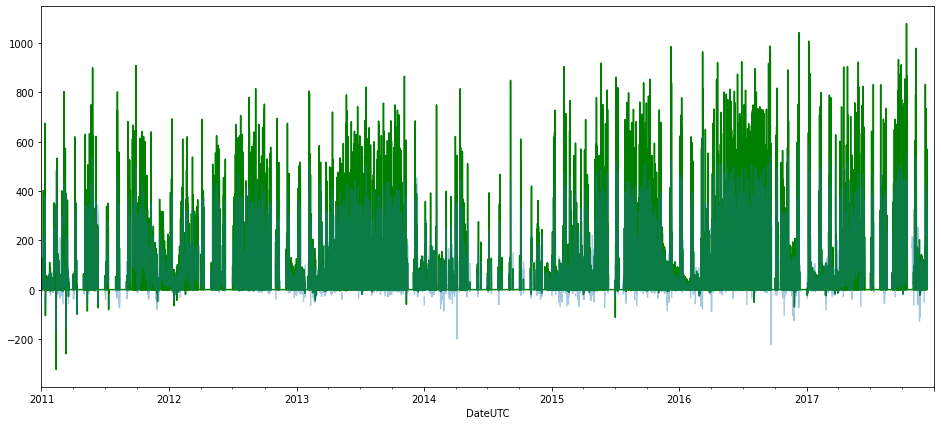

In [11]:
fig,ax=plt.subplots(figsize=(16,7))
Nalo1.LE_OK.plot(c='g')
Nalo.LE_OK.plot(alpha=0.4)

Apply corrections

In [12]:
df = Nalo.loc[:,['LE_OK']].copy(deep=True)

##get days
day_mask=(df.index.hour>6) & (df.index.hour<=18) ### filter days
days1=df[day_mask]

## get nights
night_mask=(df.index.hour>18)  ## filter nights after 18h
nights_1=df[night_mask]
night_mask2=(df.index.hour<=6) ## filter nights before 6h
nights_2=df[night_mask2]
nights1=pd.concat([nights_2, nights_1],sort=False).sort_index() 
nights1.rename(columns={'LE_OK':'LE_night'}, inplace=True)

In [13]:
days1.dropna()

LE_OK
DateUTC                      
2011-01-01 08:30:00   9.68488
2011-01-01 09:00:00  15.52700
2011-01-01 09:30:00  13.52210
2011-01-01 10:00:00  16.47600
2011-01-01 10:30:00  19.61110
...                       ...
2017-12-11 16:00:00  56.63830
2017-12-11 16:30:00  68.82540
2017-12-11 17:00:00  30.38930
2017-12-11 17:30:00  20.00360
2017-12-11 18:30:00   6.62613

[33681 rows x 1 columns]

In [14]:
nights1.dropna()

LE_night
DateUTC                      
2011-01-02 02:00:00   2.45129
2011-01-02 03:00:00 -41.25120
2011-01-02 21:00:00   4.63869
2011-01-02 22:00:00   1.70582
2011-01-02 22:30:00   2.15631
...                       ...
2017-12-11 19:30:00  10.26450
2017-12-11 20:00:00  56.88510
2017-12-11 21:00:00   4.93580
2017-12-11 22:00:00  14.85910
2017-12-11 23:00:00  12.53580

[22805 rows x 1 columns]

Apply threshold for keeping or not data

In [15]:
day_threshold = 18 # minimum 18 values out of 24 1/2 hours (no more than 3hours missing)
night_threshold = 12 # minimum 12 values out of 24 1/2 hours (no more than 6hours missing)

In [16]:
days1.resample('D').count()

LE_OK
DateUTC          
2011-01-01     16
2011-01-02     16
2011-01-03     23
2011-01-04      0
2011-01-05      0
...           ...
2017-12-27      0
2017-12-28      0
2017-12-29      0
2017-12-30      0
2017-12-31      0

[2557 rows x 1 columns]

In [17]:
daysok = days1.dropna().resample('D').count()

In [18]:
daysok = daysok[daysok>=day_threshold].dropna()

In [19]:
daysok

LE_OK
DateUTC          
2011-01-03   23.0
2011-01-06   24.0
2011-02-06   24.0
2011-02-12   18.0
2011-02-14   23.0
...           ...
2017-11-30   21.0
2017-12-04   19.0
2017-12-06   21.0
2017-12-09   20.0
2017-12-11   19.0

[1163 rows x 1 columns]

In [20]:
daysok_days = daysok.index

In [21]:
nightsok = nights1.dropna().resample('D').count()
nightsok = nightsok[nightsok>=night_threshold].dropna()
nightsok_days = nightsok.index

In [22]:
len(nightsok_days)

1130

In [23]:
len(daysok_days)

1163

In [24]:
days_to_keep = nightsok_days.intersection(daysok_days)

Now let's get back to the 1/2h data

In [25]:
days1.index.floor('D')

DatetimeIndex(['2011-01-01', '2011-01-01', '2011-01-01', '2011-01-01',
               '2011-01-01', '2011-01-01', '2011-01-01', '2011-01-01',
               '2011-01-01', '2011-01-01',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='DateUTC', length=61368, freq=None)

In [26]:
days1_2 = days1[days1.index.floor('D').isin(days_to_keep)]
nights1_2 = nights1[nights1.index.floor('D').isin(days_to_keep)]

In [27]:
days_interpolated = days1_2.groupby(days1_2.index.date).apply(lambda x: x.sum()*(1+(24-x.count())/24))
nights_interpolated = nights1_2.groupby(nights1_2.index.date).apply(lambda x: x.sum()*(1+(24-x.count())/24))

In [28]:
Daily_processed_data = days_interpolated+nights_interpolated.rename(columns={'LE_night':'LE_OK'})

In [29]:
ET_Nalo=3600*Daily_processed_data['LE_OK']/2.5104e06


In [30]:
ET_Nalo.rename('ET_mm/d',inplace=True)

2011-01-03    1.888369
2011-01-06    4.626758
2011-02-06    5.300850
2011-02-14    6.132482
2011-02-15    3.064245
                ...   
2017-11-26    1.975407
2017-11-27    1.601299
2017-11-28    1.480402
2017-11-29    1.576573
2017-11-30    1.588681
Name: ET_mm/d, Length: 902, dtype: float64

<AxesSubplot:>

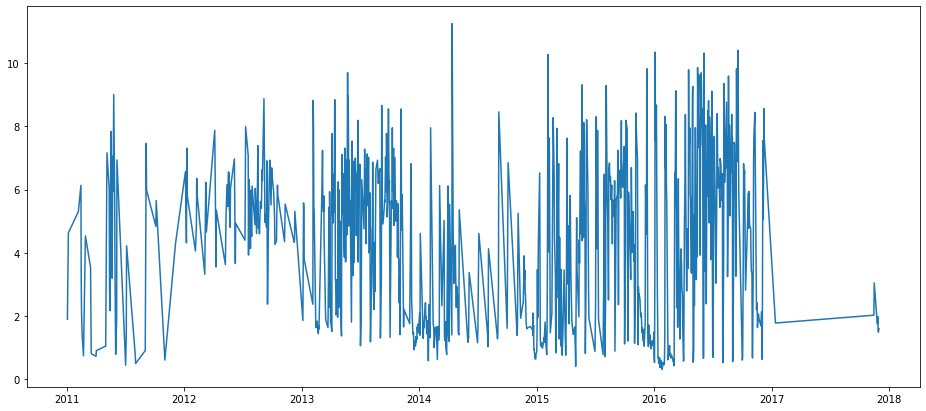

In [31]:
ET_Nalo.plot(figsize=(16,7))

# Now create a function from this

In [32]:
def filter_interpolate_data(df,day_threshold=18,night_threshold=12):
    """
    function that process differently nights & days data:
    both are filtered: 
    data during the day are filtered out when there are less than day_threshold number of values
    data during the night are filtered out when there are less than night_threshold number of values

    then the daily sum of fluxes is computed. When data is missing, the daily flux is completed 
    with the factor : (number of missing data) / 24 (if data is half hourly)
    so that flux_daiy_total = available_flux_daily ( 1 + number_of_missing_data/24)
    
    Then day and night contributions are summed up.
    """
    ##get days
    days1=df[(df.index.hour>6) & (df.index.hour<=18)] ### filter days
    days1 = days1.rename(columns={days1.columns[0]:'LE_day'})

    ## get nights
    nights1=df[(df.index.hour<=6) | (df.index.hour>18)] ### filter nights
    nights1 = nights1.rename(columns={nights1.columns[0]:'LE_night'})

    # filter out day data
    daysok = days1.dropna().resample('D').count()
    daysok = daysok[daysok>=day_threshold].dropna()
    daysok_days = daysok.index
    
    # filter out night data
    nightsok = nights1.dropna().resample('D').count()
    nightsok = nightsok[nightsok>=night_threshold].dropna()
    nightsok_days = nightsok.index

    days_to_keep = nightsok_days.intersection(daysok_days)

    days1_2 = days1[days1.index.floor('D').isin(days_to_keep)]
    nights1_2 = nights1[nights1.index.floor('D').isin(days_to_keep)]

    # compute daily sum for both day and night data
    days_interpolated = days1_2.groupby(days1_2.index.date).apply(lambda x: x.sum()*(1+(24-x.count())/x.count()))
    nights_interpolated = nights1_2.groupby(nights1_2.index.date).apply(lambda x: x.sum()*(1+(24-x.count())/x.count()))

    # add up the two contributions
    Daily_processed_data = days_interpolated+nights_interpolated.rename(columns={'LE_night':'LE_day'})

    return Daily_processed_data

In [35]:
df_nalo = Nalo.loc[:,['LE_OK']].copy(deep=True)
df_nalo2 = Nalo[Nalo.flagLE==1]  ### flag ==1 --> quality of the data
df_nalo2 = pd.DataFrame(df_nalo2['LE_OK'])

In [55]:
ET_Nalo=1800*filter_interpolate_data(df_nalo)['LE_day']/2.5104e06

In [56]:
ET_Nalo2=1800*filter_interpolate_data(df_nalo,day_threshold=20,night_threshold=16)['LE_day']/2.5104e06

In [57]:
ET_Nalo3=1800*filter_interpolate_data(df_nalo,day_threshold=12,night_threshold=6)['LE_day']/2.5104e06

In [58]:
ET_Nalo4=1800*filter_interpolate_data(df_nalo2)['LE_day']/2.5104e06

In [59]:
ET_Nalo.rename('ET_mm/d',inplace=True)
ET_Nalo2.rename('ET_mm/d',inplace=True)
ET_Nalo3.rename('ET_mm/d',inplace=True)
ET_Nalo3.rename('ET_mm/d',inplace=True)

2011-01-02    0.278336
2011-01-03    0.953002
2011-01-06    2.328155
2011-01-30    0.266075
2011-02-06    2.687353
                ...   
2017-11-29    0.830406
2017-11-30    0.808812
2017-12-02    0.405310
2017-12-08    4.936289
2017-12-11    1.189010
Name: ET_mm/d, Length: 1328, dtype: float64

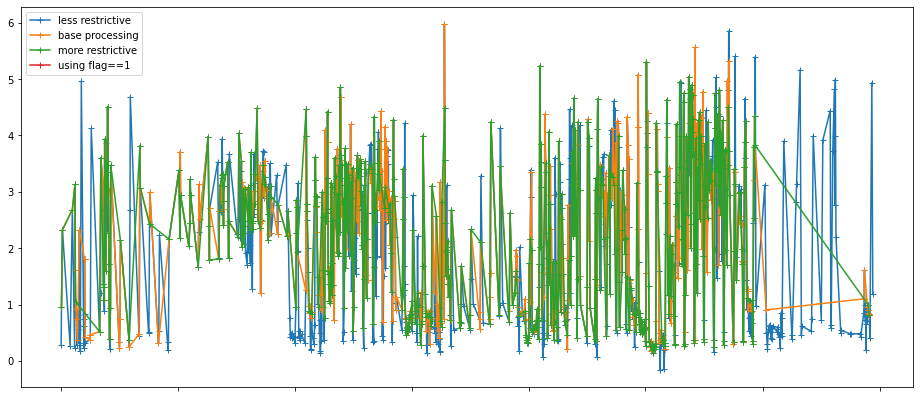

In [60]:
ET_Nalo3.plot(figsize=(16,7),marker='+',label='less restrictive')
ET_Nalo.plot(figsize=(16,7),marker='+',label='base processing')
ET_Nalo2.plot(figsize=(16,7),marker='+',label='more restrictive')
ET_Nalo4.plot(figsize=(16,7),marker='+',label='using flag==1')
plt.legend()
#ET_Nalo2.plot(figsize=(16,7),marker='+', linestyle='none')


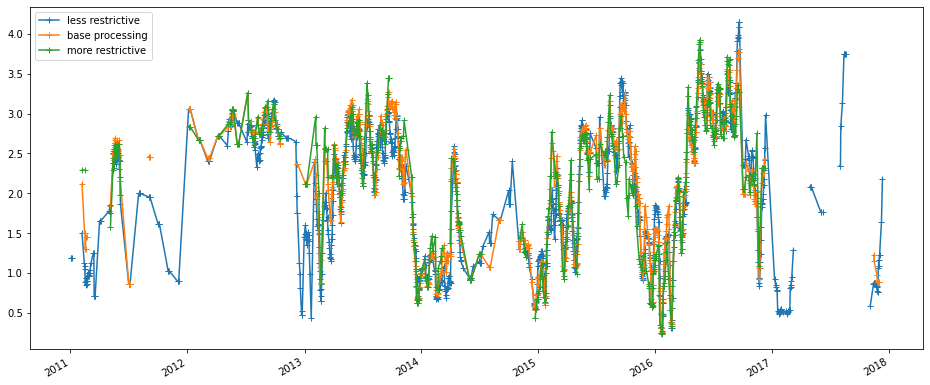

In [61]:
ET_Nalo.index = pd.to_datetime(ET_Nalo.index)
ET_Nalo2.index = pd.to_datetime(ET_Nalo2.index)
ET_Nalo3.index = pd.to_datetime(ET_Nalo3.index)

ET_Nalo3.rolling('20D',min_periods=3,center=True).mean().plot(figsize=(16,7),marker='+',label='less restrictive')
ET_Nalo.rolling('20D',min_periods=3,center=True).mean().plot(figsize=(16,7),marker='+',label='base processing')
ET_Nalo2.rolling('20D',min_periods=3,center=True).mean().plot(figsize=(16,7),marker='+',label='more restrictive')
plt.legend()